## Graph Neural Network Property Predictor


## Imports

In [3]:
# Main Imports
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

# Profiling
import cProfile
import pstats
from pstats import SortKey

# Import Local Files
from model import GNN
from utils.config import FEATURE_NAMES, RESIDUAL_G_FEATURES, MODEL_CONFIG
import utils.data_utils as DataUtils

## Execution

Generating graphs...
Train graph: 1000 nodes, 99769 edges
Test graph: 1000 nodes, 99670 edges

Processing graph data...
Target value for this session: 0.199491

Initializing model...
Node feature dimension: 12
FEATURE_NAMES length: 12
Model parameters: 11649

Model configuration:
  hidden_dim: 64
  num_layers: 3
  dropout_rate: 0.2
  batch_norm: True
  layer_norm: False
  residual: True

Training model...

Feature Statistics (Initial):
Target Feature: GMinus_Density

Train Graph:
Min degree in G/G': 158
Num nodes in G/G': 996

Test Graph:
Min degree in G/G': 155
Num nodes in G/G': 996

Training Progress:
Epoch   0: Train Loss = 0.3813, Test Loss = 0.0003, Accuracy: 99.50%, Time = 2.47s
Epoch   1: Train Loss = 0.1591, Test Loss = 0.0048, Accuracy: 11.20%, Time = 2.20s
Epoch   2: Train Loss = 0.0833, Test Loss = 0.0129, Accuracy: 0.00%, Time = 2.25s
Epoch   3: Train Loss = 0.0896, Test Loss = 0.0159, Accuracy: 0.00%, Time = 2.28s
Epoch   4: Train Loss = 0.0866, Test Loss = 0.0163, Accura

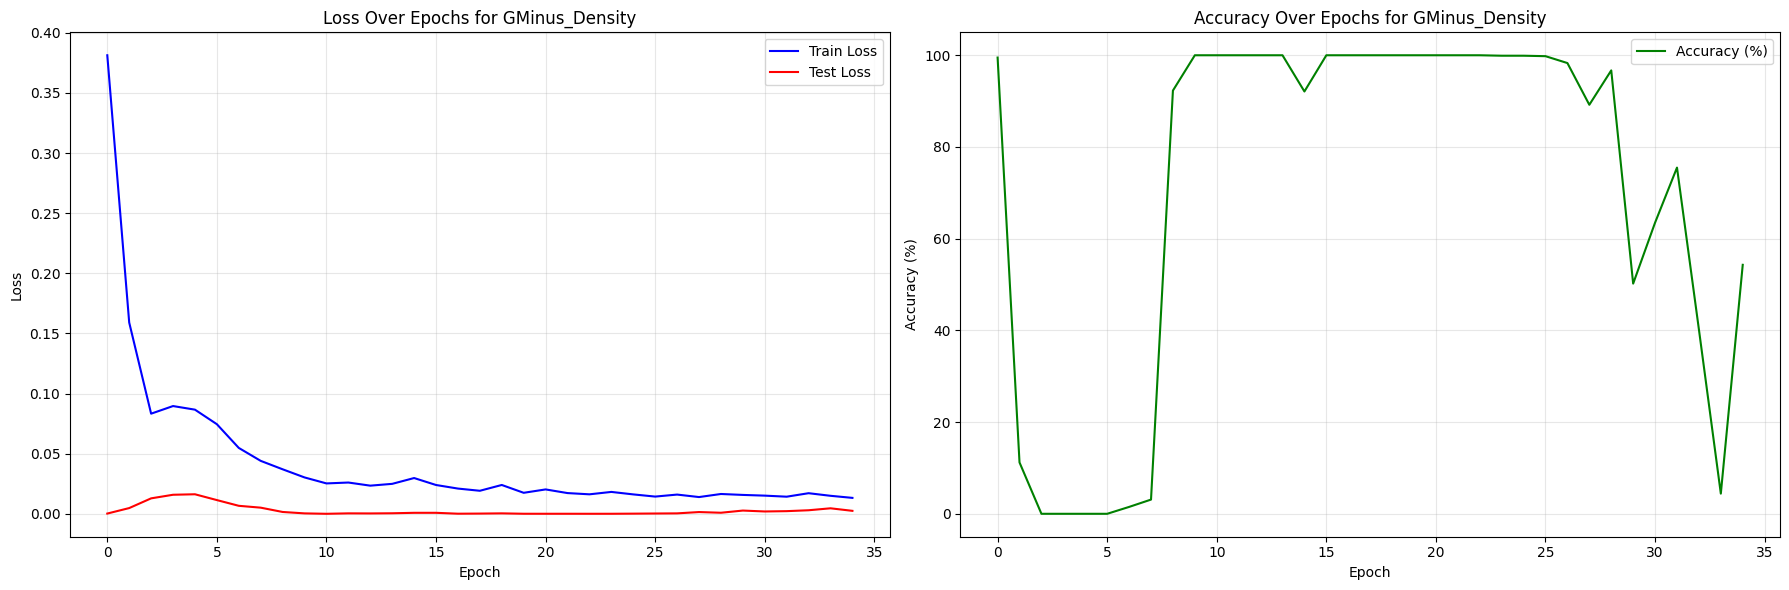


Final Test Metrics:
Target value: 0.199491
test_loss: 0.002493
mae: 0.047708
accuracy_5pct: 2.80%
accuracy_10pct: 5.70%
accuracy_20pct: 19.70%
accuracy_abs0.01: 2.80%
accuracy_abs0.05: 54.10%
accuracy_abs0.1: 99.60%
r2_score: 0.000000
rmse: 0.049926

Model Predictions Analysis:
Average prediction: 0.246484
Actual value: 0.199491
Average absolute error: 0.047708
Standard deviation of predictions: 0.016862


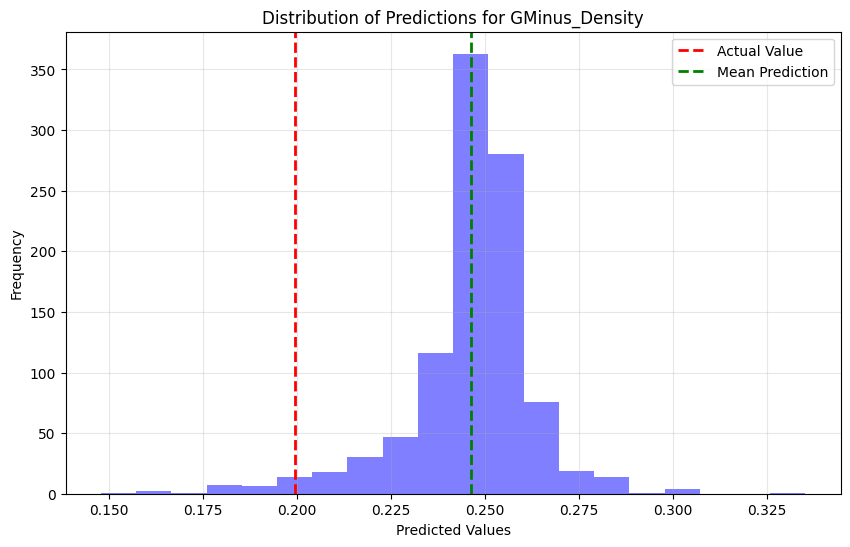

In [4]:
# Profile the main training routine
profiler = cProfile.Profile()
profiler.enable()

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Select target feature for analysis
target_feature = "GMinus_Density"

# Make sure the user only selects a feature in P(G/G')
if target_feature not in RESIDUAL_G_FEATURES:
    raise ValueError(
        f"Invalid target feature: {target_feature}\n"
        f"Target feature must be one of the following G/G' metrics:\n"
        f"{', '.join(RESIDUAL_G_FEATURES)}"
    )

target_idx = RESIDUAL_G_FEATURES.index(target_feature)

# Generate different graphs for training and test to test generalization
print("Generating graphs...")
G_train, selected_nodes_train = DataUtils.generate_graph(num_nodes=1000, edge_prob=0.2)
G_test, selected_nodes_test = DataUtils.generate_graph(num_nodes=1000, edge_prob=0.2)

print(f"Train graph: {len(G_train)} nodes, {G_train.number_of_edges()} edges")
print(f"Test graph: {len(G_test)} nodes, {G_test.number_of_edges()} edges")

print("\nProcessing graph data...")
train_data = DataUtils.process_graph_data(G_train, selected_nodes_train, target_idx)
test_data = DataUtils.process_graph_data(G_test, selected_nodes_test, target_idx)

# Print target value to understand scale for accuracy calculation
target_val = test_data.y.item()
print(f"Target value for this session: {target_val:.6f}")

# Initialize Model
print("\nInitializing model...")
node_feature_dim = train_data.x.shape[1]
print(f"Node feature dimension: {node_feature_dim}")
print(f"FEATURE_NAMES length: {len(FEATURE_NAMES)}")

# Make sure the dimensions match
if node_feature_dim != len(FEATURE_NAMES):
    print(f"Warning: Feature dimension mismatch! Expected {len(FEATURE_NAMES)}, got {node_feature_dim}")

model = GNN(node_feature_dim=len(FEATURE_NAMES))
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

# Print model configuration
print("\nModel configuration:")
for k, v in MODEL_CONFIG.items():
    print(f"  {k}: {v}")

# Train model
print("\nTraining model...")
losses, trained_model = model.train_model(
    model, 
    train_data=train_data,
    test_data=test_data, 
    target_idx=target_idx
)

# Calculate elapsed time and profiling results
profiler.disable()
print("\nProfiling Results:")
stats = pstats.Stats(profiler).sort_stats(SortKey.TIME)
stats.print_stats(20)  # Show top 20 time-consuming functions

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot training and test loss
epochs = [loss['epoch'] for loss in losses]
train_losses = [loss['train_loss'] for loss in losses]
test_losses = [loss['test_loss'] for loss in losses] 
accuracies = [loss['accuracy'] for loss in losses]

ax1.plot(epochs, train_losses, 'b-', label='Train Loss')
ax1.plot(epochs, test_losses, 'r-', label='Test Loss')
ax1.set_title(f'Loss Over Epochs for {target_feature}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(epochs, accuracies, 'g-', label='Accuracy (%)')
ax2.set_title(f'Accuracy Over Epochs for {target_feature}')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Get final test metrics
test_metrics = trained_model.evaluate(test_data, target_idx)
print("\nFinal Test Metrics:")
print(f"Target value: {target_val:.6f}")
for metric, value in test_metrics.items():
    if 'accuracy' in metric:
        print(f"{metric}: {value:.2f}%")
    else:
        print(f"{metric}: {value:.6f}")

# Visualize predictions vs actual
print("\nModel Predictions Analysis:")
trained_model.eval()
with torch.no_grad():
    output = trained_model(test_data)
    target = test_data.y.reshape(-1, 1).expand(output.shape[0], -1)
    
    predictions = output.cpu().numpy().flatten()
    actuals = target.cpu().numpy().flatten()
    
    # Calculate average prediction and error
    avg_prediction = np.mean(predictions)
    avg_error = np.mean(np.abs(predictions - actuals))
    std_predictions = np.std(predictions)
    
    print(f"Average prediction: {avg_prediction:.6f}")
    print(f"Actual value: {actuals[0]:.6f}")
    print(f"Average absolute error: {avg_error:.6f}")
    print(f"Standard deviation of predictions: {std_predictions:.6f}")
    
    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.hist(predictions, bins=20, alpha=0.5, color='blue')
    plt.axvline(actuals[0], color='red', linestyle='dashed', linewidth=2, label='Actual Value')
    plt.axvline(avg_prediction, color='green', linestyle='dashed', linewidth=2, label='Mean Prediction')
    plt.xlabel('Predicted Values')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Predictions for {target_feature}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()